# Import data set

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
feats_to_keep = ['num_likes', 'text_str']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("drive/MyDrive/story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [5]:
target = 'num_likes'

# Divide texts

In [6]:
nb_splits = 3

In [7]:
cols = ['split_'+ str(i) for i in range(1, nb_splits+1)]

def split_text(row):
  nb_splits

  l = len(row['text_str'])
  chars = int(l/nb_splits)

  for i, col in zip(range(0, l, chars), cols):  
      row[col] = row['text_str'][ i : i+chars];  
  return row

In [8]:
from tqdm import tqdm
tqdm.pandas()
df = df.progress_apply(split_text, axis=1)

100%|██████████| 18248/18248 [00:30<00:00, 598.28it/s]


In [9]:
df['story_id'] = df.index.tolist()

In [10]:
df = df.melt(id_vars=['story_id', target], value_vars=cols)

In [11]:
df = df.sort_values(by=['story_id', 'variable']).reset_index(drop=True)

In [12]:
X = df[['value', 'story_id']]
y = df[target]
story_id = df.story_id

# Binarize target

In [13]:
threshold = np.quantile(y, 0.7)
threshold

13.0

In [14]:
print(f'It corresponds to {100*len(df[df[target]<=threshold][target])/len(df):.2f} percent of the stories being bad.')

It corresponds to 71.03 percent of the stories being bad.


In [15]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

# Split data train val test

In [16]:
X.shape, y.shape

((54744, 2), (54744, 1))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3, 
                                                    random_state=42,
                                                    shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                test_size=.5, 
                                                random_state=42,
                                                shuffle=False)

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

((38320, 2), (8212, 2), (8212, 2), (38320, 1), (8212, 1), (8212, 1))

In [18]:
X_train = X_train.reset_index()[['value', 'story_id']]
X_val = X_val.reset_index()[['value', 'story_id']]
X_test = X_test.reset_index()[['value', 'story_id']]

In [19]:
X_train_index = X_train.story_id
X_val_index = X_val.story_id
X_test_index = X_test.story_id


# Import Transformer

In [20]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 37.7 MB/s 
     |████████████████████████████████| 596 kB 65.2 MB/s 
     |████████████████████████████████| 101 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [21]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = TFAutoModelForSequenceClassification.from_pretrained("ilan541/OncUponTim")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ilan541/OncUponTim.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


# Prepare model

In [22]:
model.layers[0].trainable=False

In [23]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 592,130
Non-trainable params: 124,055,040
_________________________________________________________________


# Prepare data 

In [24]:
X_train.shape

(38320, 2)

In [25]:
%%time
max_length = 512
X_train = tokenizer(X_train.value.tolist(), 
                    truncation=True, 
                    padding='max_length', 
                    max_length=max_length)

X_test = tokenizer(X_test.value.tolist(), 
                   truncation=True, 
                   padding='max_length', 
                   max_length=max_length)

X_val = tokenizer(X_val.value.tolist(), 
                  truncation=True, 
                  padding='max_length', 
                  max_length=max_length)

CPU times: user 2min 19s, sys: 3.21 s, total: 2min 22s
Wall time: 1min 34s


In [26]:
len(X_train['input_ids'])

38320

In [27]:
X_train = [np.array(X_train.input_ids)]
X_test = [np.array(X_test.input_ids)]
X_val = [np.array(X_val.input_ids)]

In [28]:
X_train[0].shape, y_train.shape

((38320, 512), (38320, 1))

In [29]:
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

In [30]:
X_train[0].shape, y_train.shape

((38320, 512), (38320,))

# Train model

In [31]:
import tensorflow as tf

In [32]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', 
              loss=LOSS,
              metrics='accuracy')

In [ ]:
%%time

model.fit(X_train, y_train, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          epochs=1)

1198/1198 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.7101

In [ ]:
! git config --global credential.helper store
! huggingface-cli login

In [ ]:
model.push_to_hub("OncUponTim")

# Get mean of the logits of the same text

In [33]:
def get_mean_pred(X, X_index, y, model, y_pred):
  #y_pred = model.predict(X)

  y_pred_df = pd.DataFrame()
  y_pred_df['story_id'] = X_index.values
  y_pred_df['y_pred_0'] = y_pred.logits[:,0]
  y_pred_df['y_pred_1'] = y_pred.logits[:,1]

  y_pred_df = y_pred_df.groupby('story_id').mean()

  y_true_df = pd.DataFrame()
  y_true_df['story_id'] = X_index.values
  y_true_df['y_true'] = y

  y_true_df = y_true_df.groupby('story_id').mean()


  return y_pred_df, y_true_df

In [ ]:
# %%time
# y_pred = model.predict(X_train)
# y_pred_train, y_true_train = get_mean_pred(X_train, X_train_index, y_train, model, y_pred)
# y_true_train = np.array(y_true_train.y_true)
# y_pred_train = np.array(y_pred_train)

In [34]:
# %%time
# y_pred = model.predict(X_test)
# y_pred_test, y_true_test = get_mean_pred(X_test, X_test_index, y_test, model, y_pred)
# y_true_test = np.array(y_true_test.y_true)
# y_pred_test = np.array(y_pred_test)

CPU times: user 48.3 s, sys: 7.91 s, total: 56.2 s
Wall time: 5min 39s


In [70]:
# %%time
# y_pred = model.predict(X_val)
# y_pred_val, y_true_val = get_mean_pred(X_val, X_val_index, y_val, model, y_pred)
# y_true_val = np.array(y_true_val.y_true)
# y_pred_val = np.array(y_pred_val)

CPU times: user 44.1 s, sys: 8.84 s, total: 53 s
Wall time: 5min 35s


# Results

In [35]:
# apply softmax to each row --> probability (for AUC)
from scipy.special import softmax

# argmax: get 0 and 1

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [41]:
def display_results(y_pred_all, y_true, recall_value=None, precision_value=None):
  # get probability
  y_probs = softmax(y_pred_all)

  # get prediction
  y_pred = np.argmax(y_pred_all, axis=1)

  # classification report
  print(classification_report(y_true, y_pred))
  print('\n')

  # confusion matrix
  print('Confusion matrix:')
  print(confusion_matrix(y_true, y_pred))
  print('\n')


  # roc
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probs[:,1])
  auc = roc_auc_score(y_true, y_probs[:,1])

  plt.figure(figsize=(10,10))
  plt.plot(fpr, tpr, label=f'transformer, AUC={auc:.4f}')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title("Receiver operating characteristic ")
  plt.xlabel('rate of false positives')
  plt.ylabel('rate of true positives')
  plt.legend(loc='best')
  plt.show()
  print('\n')

  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')

  print('\n')


  # play with threshold
  precision, recall, thresholds = precision_recall_curve(y_true, y_probs[:,1])

  x = np.linspace(0,1, num=len(precision))
  if recall_value:
    y = interp1d(recall, precision)
    precision_value = y(recall_value)
  if precision_value:
    y = interp1d(precision, recall)
    recall_value = y(precision_value)
  plt.figure(figsize=(10,10))
  plt.plot(recall, precision, label='transformer')
  plt.title("precision-recall curve")
  plt.plot(x, [precision_value]*len(recall), label=f'{precision_value:.2f}')
  plt.axvline(recall_value, label=f'{recall_value:.2f}')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.show()

  if len(thresholds)<len(recall):
    thresholds = np.append(thresholds,0)
  y_thresholds = interp1d(recall, thresholds)
  threshold_value = y_thresholds(recall_value)
  print('\n')
  print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.2f},\
  and the threshold is equal to {threshold_value:.2f}.')

  y_pred = (y_probs[:,1] >= threshold_value).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')
  print('\n')
  print(f"Confusion matrix when p={threshold_value:.2f}:")
  print(confusion_matrix(y_true, y_pred))
  print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      1934
         1.0       0.57      0.09      0.16       804

    accuracy                           0.71      2738
   macro avg       0.65      0.53      0.49      2738
weighted avg       0.68      0.71      0.63      2738



Confusion matrix:
[[1879   55]
 [ 731   73]]




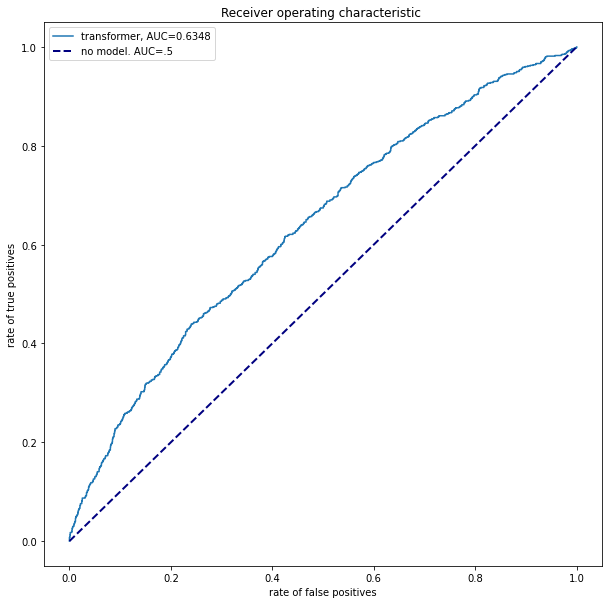



9.08% of the good stories are rightly identified.
2.84% of the bad stories are identified as good ones.




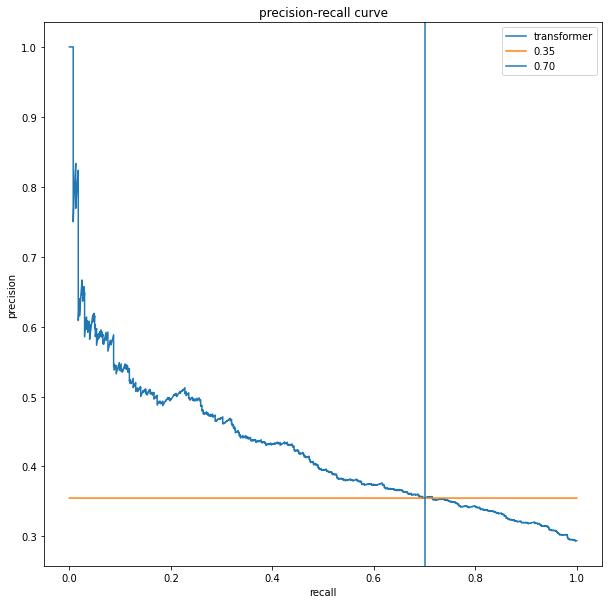



When recall is equal to 0.70, precision is equal to 0.35,  and the threshold is equal to 0.00.
69.90% of the good stories are rightly identified.
52.90% of the bad stories are identified as good ones.


Confusion matrix when p=0.00:
[[ 911 1023]
 [ 242  562]]
              precision    recall  f1-score   support

         0.0       0.79      0.47      0.59      1934
         1.0       0.35      0.70      0.47       804

    accuracy                           0.54      2738
   macro avg       0.57      0.59      0.53      2738
weighted avg       0.66      0.54      0.56      2738



In [71]:
# display_results(y_pred_val, y_true_val, recall_value=.7, precision_value=None)

              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83      1964
         1.0       0.53      0.09      0.15       774

    accuracy                           0.72      2738
   macro avg       0.63      0.53      0.49      2738
weighted avg       0.67      0.72      0.64      2738



Confusion matrix:
[[1904   60]
 [ 706   68]]




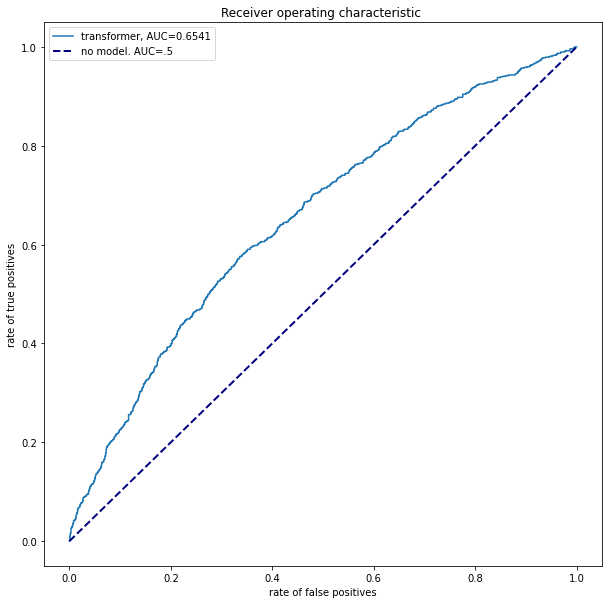



8.79% of the good stories are rightly identified.
3.05% of the bad stories are identified as good ones.




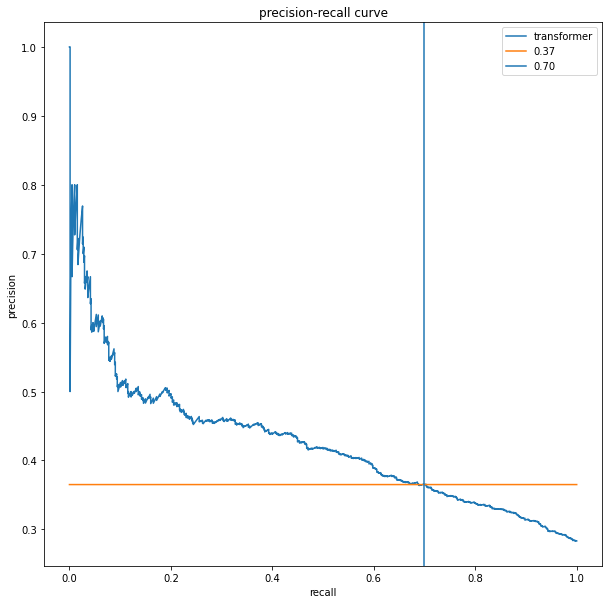



When recall is equal to 0.70, precision is equal to 0.37,  and the threshold is equal to 0.00.
69.90% of the good stories are rightly identified.
47.86% of the bad stories are identified as good ones.


Confusion matrix when p=0.00:
[[1024  940]
 [ 233  541]]
              precision    recall  f1-score   support

         0.0       0.81      0.52      0.64      1964
         1.0       0.37      0.70      0.48       774

    accuracy                           0.57      2738
   macro avg       0.59      0.61      0.56      2738
weighted avg       0.69      0.57      0.59      2738



In [44]:
# display_results(y_pred_test, y_true_test, recall_value=.7, precision_value=None)

# Examples

In [58]:
def split_text(text, nb_splits):
  cols = ['split_'+ str(i) for i in range(1, nb_splits+1)]

  l = len(text)
  chars = int(l/nb_splits)

  out = []

  for i in range(0, l, chars):  
    out.append(text[ i : i+chars])
  return out

def get_probs(list_of_portions):
  y_pred_logits_0 = []
  y_pred_logits_1 = []
  for text in list_of_portions:
    inp = tokenizer(text, return_tensors='tf')
    y_pred = model(inp)
    y_pred_logits_0.append(y_pred.logits[:,0])
    y_pred_logits_1.append(y_pred.logits[:,1])

  return np.mean(y_pred_logits_0), np.mean(y_pred_logits_1)


In [50]:
# this is supposed to be a good story
text = \
"""
The night is thick and heavy with clouds when I paint the front of The House yellow. I paint quickly and quietly. I don’t want to wake my neighbor up. The brush goes shhh shhh against the wall and even that is loud. 

My feet crunch on gravel as I finish up and slip into my home. 

My neighbor’s cursing wakes me up in the morning. I hear fuck! and shit! I split the blinds with two fingers. The sun shines very bright and I squint to see my other neighbors file outside. They see the yellow paint and shake their heads. One of them points at my home. I come away from the window. Knock knock. I do not answer. I make myself toast with a poached egg. I eat it plain. Butter has a strange, slimy texture and most jams are too sweet for my taste. 

They pound on the door. The doorknob rattles in its socket before I hear silence on my front porch again. 

My neighbors assume I painted The House. They are right, but it’s still insulting that they point to me first.

Upon purchase, my new neighbor repainted The House beige before moving equally bland furniture (and herself) inside. I must fix it. She does not understand that each house claims life as we do. Their creaks are small sighs and groans, their breath the wind that flutters curtains when their mouths are unlocked. Each house is individual in personality. They have different mannerisms, likes and dislikes that can influence whoever its inhabitant might be at the time. Often, though, its influence is overruled by tenants that bustle about, creating their own noises that muffle their homes.  

I can hear them. I hear anger when doors slam shut, peace when furniture is aligned and floors are swept clean. Houses do not have control over their appearance, so I help them. I listen and give them a color true to their individuality. 

The House in question, which you could say is my current “client,” is bubbly, but prone to sickness and somewhat oblivious to the struggles of others. It loves its inhabitants—most of the time—and wishes to give them a cozy embrace. Most of all, The House is very particular about its appearance and becomes incensed when the smallest thing is not quite right. Right now, it is sulking. The little yellow I gave it placated it, but soon it will demand more.  

In the afternoon I hear the grrr grrr of trucks and metallic clanking and deep voices shouting. Big men in loose denim pants and ugly T-shirts paint The House back to beige. My neighbor comes onto her lawn to survey the men, pointing out the spots that need extra paint. The painters finish quickly, taking my neighbor’s cash and leaving extra paint cans and brushes and crinkled plastic tarps. 

The House strains against its new skin. It pummels its beige bonds with angry fists and wails It’s so ugly! The neighboring houses think it silly and childish, but they are too old to remember what it was like to be a child. I will The House to be patient. Its paint is still wet. 


"""


In [69]:
nb_splits = 3
splits = split_text(text, nb_splits)

y_logits_0, y_logits_1 = get_probs(splits)
if np.argmax([y_logits_0, y_logits_1]) == 0:
  print('Bad text')
else:
  print('Wha, good text')


Bad text
